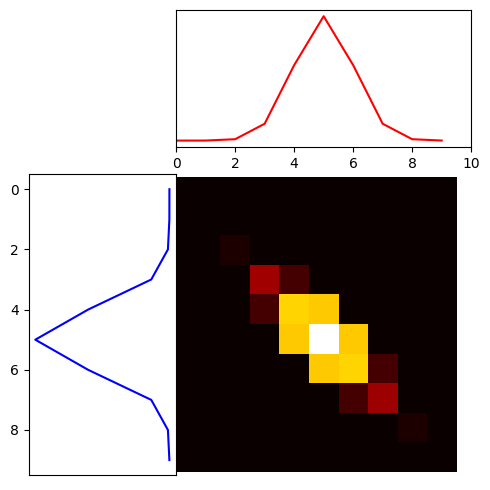

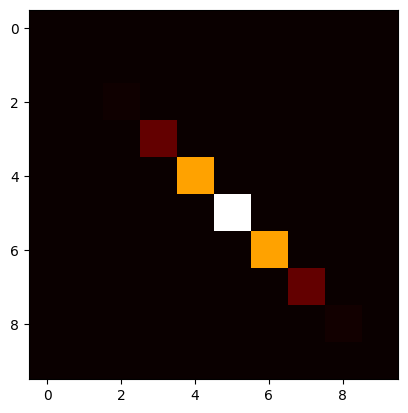

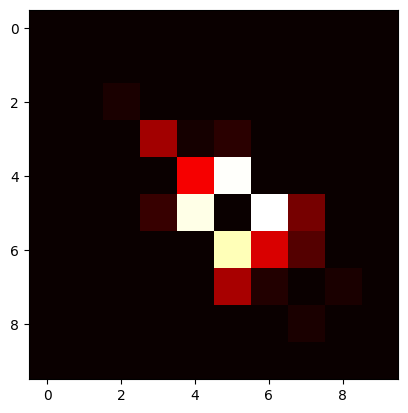

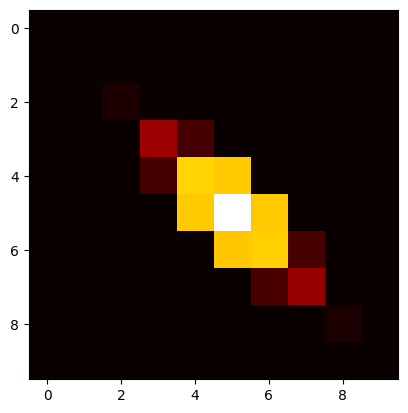

In [2]:
import numpy as np
import torch
import ot, math
from ot.datasets import make_1D_gauss as gauss
from sparse_ot.sparse_repr import get_gamma as get_gamma
from sparse_ot.uot_mmd import solve_apgd
from sparse_ot.utils import get_G, get_dist, offd_dist, postprocess_gamma
import ot.plot
import matplotlib.pyplot as plt

m, n = 10, 10
device = torch.device("cuda")
x = torch.arange(m).float().to(device)
y = torch.arange(n).float().to(device)
lda = 100

a = torch.from_numpy(gauss(m, 5, 1)).float().to(device)
b = torch.from_numpy(gauss(n, 5, 1)).float().to(device)
v = {1: a, 2: b}

max_itr = 500

def get_cost_G(x, y, khp, ktype, p=2):
    # None means taking median-heuristic
    C = get_dist(x, y, p)
    C = C/C.max()
    
    G1 = get_G(x=x, y=x, khp=khp, ktype=ktype)
    G2 = get_G(x=y, y=y, khp=khp, ktype=ktype)
    G = {1: G1, 2: G2}
    return C, G

C, G = get_cost_G(x, y, khp=1, ktype="rbf")

def plot_gamma(a, b, gamma, title):
    plt.clf()
    plt.imshow(gamma.cpu().numpy(), cmap="hot")
    plt.savefig('{}.jpg'.format(title), bbox_inches = 'tight', pad_inches = 0.25)
    plt.show()

orig_gamma, obj_itr = solve_apgd(C, G[1], G[2], v[1], v[2], max_itr, lda, prog=1)

# plot_gamma(v[1], v[2], orig_gamma, "uot")


from matplotlib import gridspec

def plot1D_mat(a, b, M, title=''):
    na, nb = M.shape

    gs = gridspec.GridSpec(3, 3)

    xa = np.arange(na)
    xb = np.arange(nb)
    
    plt.figure(2, figsize=(5, 5))

    ax1 = plt.subplot(gs[0, 1:])
    plt.plot(xb, b, 'r', label='Target distribution')
    plt.yticks(())
    # plt.title(title)

    ax2 = plt.subplot(gs[1:, 0])
    plt.plot(a, xa, 'b', label='Source distribution')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xticks(())

    plt.subplot(gs[1:, 1:], sharex=ax1, sharey=ax2)
    plt.imshow(M, interpolation='nearest', cmap='hot')
    plt.axis('off')

    plt.xlim((0, nb))
    plt.tight_layout()
    plt.subplots_adjust(wspace=0., hspace=0.2)
    plt.savefig('{}.jpg'.format(title), bbox_inches = 'tight', pad_inches = 0.25)
    plt.show()

plot1D_mat(v[1].cpu().numpy(), v[2].cpu().numpy(), orig_gamma.cpu().numpy(), "uot")

# for K in [10, 20, 50]:
#     gamma, S_i, S_j = get_gamma(C, G[1], G[2], v[1], v[2], max_itr, K, lda)
#     p_gamma = postprocess_gamma(gamma, S_i, S_j, m, n)
#     # plot_gamma(v[1], v[2], p_gamma, f"sot_k={K}")
#     plot1D_mat(v[1].cpu().numpy(), v[2].cpu().numpy(), p_gamma.cpu().numpy(), f"sot_k={K}")
K = 50

for s_eps in [0.9, 1e-1, 1e-2]:
    s = int(np.ceil(100/K*math.log(1/s_eps)))
    
    gamma_stoch_k, S_i_stoch_k, S_j_stoch_k = get_gamma(C, G[1], G[2], v[1], v[2], max_itr, K=K, lda=lda, s=s, all_gamma=0, conv_crit=0)
    p_gamma_stoch_k = postprocess_gamma(gamma_stoch_k, S_i_stoch_k, S_j_stoch_k, m, n)
    plot_gamma(v[1], v[2], p_gamma_stoch_k, "sot_s={}".format(s))